# RNN based on time series: Predict Action and next steps

We aim to predict the next steps and actions based on time series

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [1]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category
from Process_Training_Data_2 import extend_dataset
from Process_Training_Data_2 import normalize_data
from Process_Training_Data_2 import print_model_df_analysis
from Process_Training_Data_2 import group_by_path
from Process_Training_Data_2 import get_mean_error
from Process_Training_Data_2 import add_end_state

importing Jupyter notebook from Process_Training_Data_2.ipynb


### Get the data
First Import it using pandas

In [5]:
file = "OSPA_training_data.csv"

In [6]:
STEPS=8

dataset = Process_Training_Data_2.get_data("./data/"+file)

dataset_distances= dataset[["id_camino","D0",'D1',"D2","D3",'D4',"D5","A0","A1"]]

#exteneded_dataset = Process_Training_Data_2.extend_dataset(dataset_short,N_STEPS)
exteneded_dataset= add_end_state(dataset_distances)

action_vector = ["A0","A1"]
normed_dataset, data_stats = Process_Training_Data_2.normalize_data(exteneded_dataset, action_vector)

position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,STEPS,position)


# Action generated trajectory model

## Multi-step model using single step-multioutput model

In [7]:
model = tf.keras.models.load_model('./data/S2A_model.h5')

In [8]:
import os, sys
sys.path.append('c:\\Users\\pasky\\Documents\\Master_en_Matematicas\\PFM\\Neuronal_Networks\\path_planning')

In [9]:
from simulate_clean import get_next_state
from clean_model import tc
from clean_model import c
from clean_model import Uc
from classes import FlightState

In [10]:
def distance_error(x, z):
    distancia = math.sqrt(x**2 + z**2)
    return distancia

In [45]:
def to_adimensional(state):
    # (self.x, self.z, self.u, self.v, self.theta, self.omega, self.tail_angle, self.fa, self.cost)
    x, z, u, v, theta, omega = state
    return 2*x/c, 2*z/c, u/Uc, v/Uc, theta, omega

In [46]:
def to_dimensional(state):
    x, z, u, v, theta, omega = state
    return x * c/2, z * c/2, u * Uc, v * Uc, theta, omega

In [71]:
def generate_trajectory(model, start, target, initial_action, data_stats):
  # Evaluation step (generating trajectory using the learned model)
  # start(9), target(9)

  end_message = "max iterations reached"

  # Number of points to generate
  num_generate = 30

  # time step used in the action
  time_step = 31.534#12/tc
  
  # Get Flight status target
  FS_target = FlightState.order_as_input(to_adimensional(target[0:6]),0,0)
  
  # Get Flight status start
  FS_start = FlightState.order_as_input(to_adimensional(start[0:6]),initial_action[0], initial_action[1])
  FS_current_state = FS_start

  # Compute the initial distance
  distance_long = target - start

  # normalize and add the action to get the Neuronal Network input
  distance = norm(distance_long, data_stats)
  input_eval = tf.expand_dims([distance], 0)
  

  # Empty vector to store the actions
  trajectory_generated = []

  # Empty vector to store the actions
  actions = []

  # First point is the initial distance
  trajectory_generated.append(distance)

  # initialize cost
  cost = 0

  #initialize distance error
  distancia_error = distance_error(*distance_long[0:2])

  #initialize action vector
  actions.append(initial_action)

  # Here batch size == 1 and sequence size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      last_action = predictions[:,-1,:]
      # remove the batch dimension
      action = tf.squeeze(last_action, 0)
      
      actions.append(np.array(action))

      #Expand the action vector with the time step
      action_long = np.append(action, time_step)

      # new_state, boolean = get_next_state(current_state(9), action(2), target_state(6))
      FS_new_state, boolean = get_next_state(FS_current_state, action_long,  FS_target)
      if boolean > 0:

        # We pass the predicted point as the next input to the model
        # along with the previous hidden state
        FS_current_state = FS_new_state
        current_state= FS_current_state.get_info_formatted()
        distance_long = target - to_dimensional(current_state[0:6])

        distance = norm(distance_long, data_stats)
  
        trajectory_generated.append(distance)

        input_eval = tf.expand_dims(np.array(trajectory_generated),0)
        cost = current_state[8]

        #Error distancia = raiz(x, z, pitch, velocidad) de la suma de los cuadrados de las que estan dentro. La velocidad es... velocidad = raiz(u**2 + v**2)
        distancia_error = distance_error(*distance_long[0:2])

      elif boolean == 0:
        print("End")
        end_message = "End"
        break

      else:
        print("Error")
        end_message = "Error"
        break 

  trajectory_generated_denorm = np.apply_along_axis(denorm,1,
        trajectory_generated,data_stats)    

  return trajectory_generated_denorm, cost, actions, end_message

In [40]:
def get_trajectory_results_2(trajectoty_list, data_stats):
    results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "mean_distance","end_message"])

    for t_number in range(len(trajectoty_list)):

        initial_action = [0,0]
        start = trajectoty_list[t_number][0,-2]
        target = trajectoty_list[t_number][0,-1]

        start_time = time.time()

        trajectory, cost, actions, end_message = generate_trajectory(model, start, target, initial_action, data_stats)

        t_time = time.time() - start_time

        pred_trajectory_states = target - trajectory
        OSPA_trajectory_states =  trajectoty_list[t_number][:,0:6]

        min_len = min(len(OSPA_trajectory_states),len(trajectory))

        mse =sklearn.metrics.mean_squared_error(OSPA_trajectory_states[0:min_len,0:2], pred_trajectory_states[0:min_len,0:2])


        results.at[t_number, "time"] = t_time
        results.at[t_number, "actions"] = np.array(actions)
        results.at[t_number, "path"] = np.array(trajectory)
        results.at[t_number, "sqrt(trajectory MSE)"] = math.sqrt(mse)
        results.at[t_number, "cost"] = cost
        results.at[t_number, 'distance_to_target'] = distance_error(*trajectory[-1,0:2])
        results.at[t_number, 'end_message'] = end_message
        results.at[t_number, "mean_distance_in_trajectory"] = get_mean_error(OSPA_trajectory_states, pred_trajectory_states, num=10, eps = 5)
        results.at[t_number, "k_value"] = abs(target[1])/abs(target[0])
        results.at[t_number, "u_at_target"] = pred_trajectory_states[-1,2]
        results.at[t_number, "v_at_target"] =distance_error(pred_trajectory_states[-1,2], pred_trajectory_states[-1,3])
        results.at[t_number, "theta_at_target"] = pred_trajectory_states[-1,4]
        "u_at_target"

    return results

In [14]:
def results_summary(results, metrics):
    results_summary = pd.DataFrame(columns = ["all","result_end", "result_error"])
    
    for metric in metrics:
        results_summary.at[metric, "result_end"] = results[metric].loc[results['end_message'] == "End"].mean()
        results_summary.at[metric, "result_error"] = results[metric].loc[results['end_message'] == "Error"].mean()
        results_summary.at[metric, "all"] = results[metric].mean()

    print(results["time"].loc[results['end_message'] == "Error"].count()/len(results))
    return results_summary

In [73]:
def plot_trajectory_2(trajectory_list, data_stats, t_number):

    initial_action = [0,0]
    start = trajectory_list[t_number][0,-2]
    target = trajectory_list[t_number][0,-1]

    trajectory, cost, actions, end_message = generate_trajectory(model, start, target, initial_action, data_stats)

    pred_trajectory_states = target - trajectory
    OSPA_trajectory_states =  trajectory_list[t_number][:,0:6]
    # ANN_trajectory_states = ANN_dataset["states"][t_number]


    plt.figure()

    plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='g', label='RNN prediction')
    # plt.plot(ANN_trajectory_states[:,0], ANN_trajectory_states[:,1], c='b', label="ANN prediction")
    plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='r', label='OSPA')
    plt.scatter(target[0],target[1], c='g', label='Goal state')
    plt.scatter(start[0], start[1], c='y', label='Start state')
    plt.title("trajectory x,z states")
    plt.legend()

    plt.show()

    fig, axs = plt.subplots(4)

    for i in range(4):

        component= i+2

        axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='b', label='RNN Prediction')
        axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='r', label='OSPA')
        axs[i].scatter(target[0],target[component], c='g', label='Goal state')
        axs[i].scatter(start[0], start[component], c='y', label='Start start')

    fig.suptitle("trajectory components (u, v, theta, q) vs x")

In [16]:
dataset_trajectories = dataset[["id_camino","C0",'C1',"C2","C3",'C4',"C5","A0","A1","initial_state", "goal_state"]]

In [17]:
trajectory_list = group_by_path(dataset_trajectories)

In [75]:
full_results= get_trajectory_results_2(trajectory_list, data_stats)

End
End
End
End
End
End
End
index 7 is out of bounds for axis 0 with size 7
End
index 7 is out of bounds for axis 0 with size 7
End
End
End
End
odeint esta hervi'o
Error
End
End
End
End
End
index 10 is out of bounds for axis 0 with size 10
End
End
End
odeint esta hervi'o
Error
End
index 10 is out of bounds for axis 0 with size 10
End
End
End
End
index 6 is out of bounds for axis 0 with size 6
End
index 9 is out of bounds for axis 0 with size 9
End
index 6 is out of bounds for axis 0 with size 6
End
End
index 11 is out of bounds for axis 0 with size 11
End
End
End
End
End
End
End
index 6 is out of bounds for axis 0 with size 6
End
End
End
End
End
End
End
End
End
End
End
End
index 6 is out of bounds for axis 0 with size 6
index 6 is out of bounds for axis 0 with size 6
End
index 6 is out of bounds for axis 0 with size 6
End
End
End
End
index 8 is out of bounds for axis 0 with size 8
End
End
End
odeint esta hervi'o
Error
End
index 8 is out of bounds for axis 0 with size 8
End
index 6 is o

In [91]:
metrics = ["time",'distance_to_target', "u_at_target","v_at_target","theta_at_target","mean_distance_in_trajectory","sqrt(trajectory MSE)", "k_value", "cost"]
results_summary(full_results, metrics)

0.04583333333333333


,all,result_end,result_error
time,0.430687,0.418477,0.684875
distance_to_target,6.29273,6.26051,6.96354
u_at_target,8.57198,8.78483,4.14087
v_at_target,8.59691,8.80838,4.1945
theta_at_target,-0.0361013,-0.0685347,0.639104
mean_distance_in_trajectory,3.851,3.86943,3.4673
sqrt(trajectory MSE),3.63092,3.67782,2.65453
k_value,0.354392,0.355918,0.322626
cost,37.2551,37.6037,29.9968


End


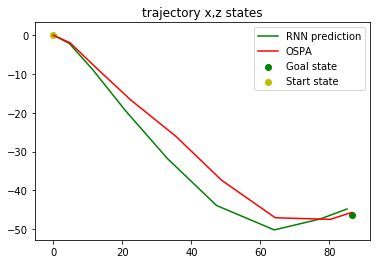

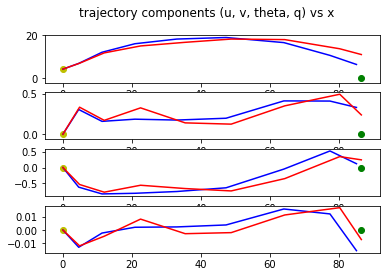

In [90]:
t_number = 23
plot_trajectory_2(trajectory_list, data_stats, t_number)